In [1]:
import matplotlib.pylab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from opt_einsum import contract,contract_path
from tqdm.auto import tqdm
import dacite
import torch
from scipy.optimize import curve_fit
from functools import partial,wraps,reduce
def _toN(t):
    return t.detach().cpu().tolist()
def _toT(t):
    return torch.as_tensor(t)
torch.set_default_tensor_type(torch.DoubleTensor)

# Magnetization Curve

In [53]:
Ising2D.get_default_params()

{'beta': 0.44068679350977147, 'h': 0}

In [65]:
data=pd.DataFrame()
options={
    'nLayers':60,
    'max_dim':12,
    'gilt_enabled':True,
    'gilt_eps':8e-7,
    'gilt_nIter':1
}
gilt_options=GILT_options(**{k[5:]:v for k,v in options.items() if k[:5]=='gilt_'})

for beta in tqdm(np.linspace(-.00001,.00001,9)+0.44068679350977147,leave=False):
    params={'beta':beta}
    model=Ising2D(params)
    
    #dimR=model.get_dimR()
    dimR=None
    layers,Ts,logTotals=HOTRG_layers(model.get_T0(),dimR=dimR,
                            max_dim=options['max_dim'],nLayers=options['nLayers'],
                            HOTRG_layer=partial(GILT_HOTRG_layer,options=gilt_options),
                            return_tensors=True)
    Ts,T_ops,logTotals=forward_observable_tensor(model.get_T0(),model.get_SZT0(),
                                    layers=layers,checkerboard=model.observable_checkerboard,
                                    return_layers=True,
                                    cached_Ts=Ts)
    for layer in range(len(Ts)):
        T,T_op,logTotal=Ts[layer],T_ops[layer],logTotals[layer]
        logZ=_toN((torch.log(trace_tensor(T))+logTotal)/2**layer)
        magnetization1=_toN(torch.abs(trace_tensor(T_op)/trace_tensor(T)))
        magnetization=_toN((trace_two_tensors(T_op)/trace_two_tensors(T))**.5)
        newRow={**params,
                **options,
                'layer':layer,
                'logZ':logZ,'magnetization':magnetization,'magnetization1':magnetization1}
        data=data.append(newRow,ignore_index=True)
#display(data)



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

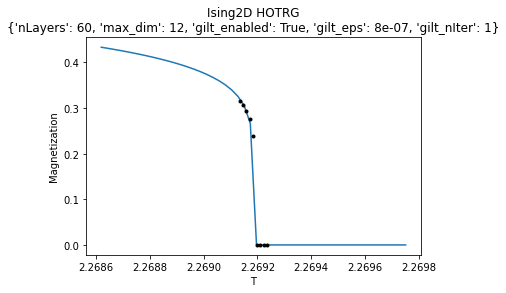

/home/wenhan/jupyter/SRG/IsingSolutions.py:24: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I,abserr=scipy.integrate.quad(integrant,0,pi,epsabs=0,epsrel=1e-12)


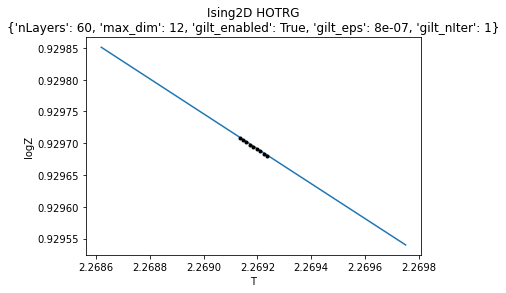

In [66]:

import IsingSolutions
importlib.reload(IsingSolutions)
from IsingSolutions import Ising2DExactSolution,Ising3DMonteCarlo

solution=Ising2DExactSolution()
nLayers=int(max(data['layer']))

def relerr(x,ref):
    return abs(x-ref)/abs(ref)

def abserr(x,ref):
    return abs(x-ref)

ls=np.linspace(min(data['beta'])-.0001,max(data['beta'])+.0001)


plt.plot(1/ls,solution.magnetization(ls))
data1=data[(data['layer']==nLayers)]
plt.plot(1/data1['beta'],data1['magnetization'],'.',color='black')
#plt.plot(1/data1['beta'],data1['magnetization1'],'x')
plt.xlabel('T')
plt.ylabel('Magnetization')
plt.title(f'{type(model).__name__} HOTRG\n{options}')
plt.show()

plt.plot(1/ls,solution.logZ(ls))
data1=data[(data['layer']==nLayers)]
plt.plot(1/data1['beta'],data1['logZ'],'.',color='black')
plt.xlabel('T')
plt.ylabel('logZ')
plt.title(f'{type(model).__name__} HOTRG\n{options}')
plt.show()
    


# TRG Evolution

In [311]:
data=pd.DataFrame()
options={
    'nLayers':60,
    'max_dim':12,
    'gilt_enabled':True,
    'gilt_eps':8e-7,
    'gilt_nIter':1,
    #'gilt_record_S':True,
}
gilt_options=GILT_options(**{k[5:]:v for k,v in options.items() if k[:5]=='gilt_'})

#params=AKLT2D.get_default_params()
#params['a2']=2.86522
#model=AKLT2D(params)
#T0,T0_op1,T0_op2=model.get_T0(),model.get_ST0(2),model.get_ST0(2)

#params=AKLT2DStrange.get_default_params()
#params['a2']=4
#model=AKLT2DStrange(params)
#T0,T0_op1,T0_op2=model.get_T0(),model.get_ST0(0)+model.get_ST0(1),model.get_ST0(0)-model.get_ST0(1)

params=Ising2D.get_default_params()
params['beta']+=0
model=Ising2D(params)
T0,T0_op1,T0_op2=model.get_T0(),model.get_SZT0(),model.get_SZT0()


reference_scaling_dimensions=[0.125,1,1.125,2]
reference_center_charge=.5

#dimR=model.get_dimR()
dimR=None

layers,Ts,logTotals=HOTRG_layers(T0,dimR=dimR,
                        max_dim=options['max_dim'],nLayers=options['nLayers'],
                        HOTRG_layer=partial(GILT_HOTRG_layer,options=gilt_options),
                        return_tensors=True)
#Ts_new,T_ops,logTotals=forward_observable_tensor(T0,T0_op1,
#                        layers=layers,checkerboard=model.observable_checkerboard,
#                        return_layers=True,
#                        cached_Ts=None)

#print(trace_two_tensors(T_ops[-1]))
    

  0%|          | 0/60 [00:00<?, ?it/s]

In [368]:
import importlib
import HOTRGZ2,TNModels,GILT,utils,ScalingDimensions,fix_gauge
importlib.reload(fix_gauge)
importlib.reload(HOTRGZ2)
importlib.reload(TNModels)
importlib.reload(ScalingDimensions)
importlib.reload(GILT)
importlib.reload(utils)
from HOTRGZ2 import HOTRG_layers,forward_observable_tensor,forward_observable_tensors,trace_tensor,trace_two_tensors,get_lattice_size,get_dist_torus_2D
from TNModels import Ising2D,AKLT2D,AKLT2DStrange
from GILT import evolve_TRG_GILT_2D,GILT_HOTRG_layer,GILT_options
from fix_gauge import fix_gauges,minimal_canonical_form,fix_gauges1
#from utils import *
from ScalingDimensions import show_effective_rank,show_diff,show_scaling_dimensions

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

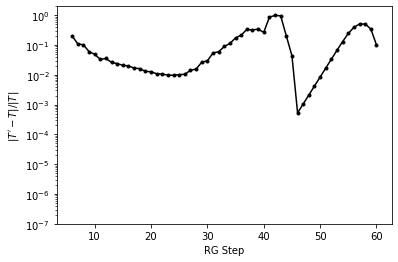

  0%|          | 0/61 [00:00<?, ?it/s]

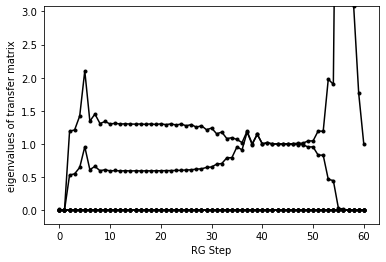

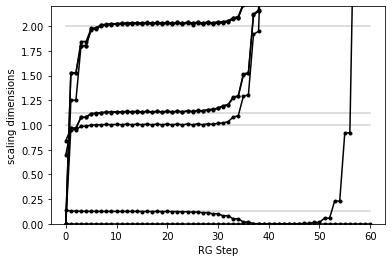

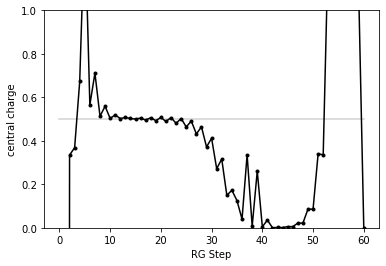

In [369]:

#print(max((a-b).norm() for a,b in zip(Ts,Ts_new)))
show_diff(fix_gauges1(Ts,is_HOTRG=True),stride=2)
#show_effective_rank(Ts)
curve=show_scaling_dimensions(Ts,loop_length=2,is_HOTRG=True,reference_scaling_dimensions=reference_scaling_dimensions,reference_center_charge=reference_center_charge)

# correlators

In [153]:
data=pd.DataFrame()

coordss=[]
for i in range(30):
    lattice_size=get_lattice_size(len(layers),spacial_dim=len(T0.shape)//2)
    th=np.random.uniform(0,np.pi/2)
    r=np.exp(np.random.uniform(np.log(1),np.log(min(lattice_size))))
    x,y=int(np.abs(r*np.cos(th))),int(np.abs(r*np.sin(th)))
    coordss.append((x,y))
    #x,y=int(lattice_size[0]-r),0
    #coordss.append((x,y))
    #x,y=int(r),0
    #coordss.append((x,y))

for coords in tqdm(coordss):
    if not(all(isinstance(c,int) and 0<=c and c<s for c,s in zip(coords,lattice_size))):continue
    if all(c==0 for c in coords):continue
        
    #T,T_op12,logTotal=forward_two_observable_tensors(T0,T0_op1,T0_op2,coords=coords,\
    #                           layers=layers,checkerboard=model.observable_checkerboard,\
    #                           cached_Ts=Ts)
    T,T_op12,logTotal=forward_observable_tensors(T0,[T0_op1,T0_op2],[(0,)*len(coords),coords],\
                               layers=layers,checkerboard=model.observable_checkerboard,\
                               cached_Ts=Ts)
    correlation=_toN(trace_tensor(T_op12)/trace_tensor(T))
    newRow={**params,
        **options,
        'x':coords[0],'y':coords[1],
        'correlation':correlation,}
    
    data=data.append(newRow,ignore_index=True)
#data

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

/home/wenhan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


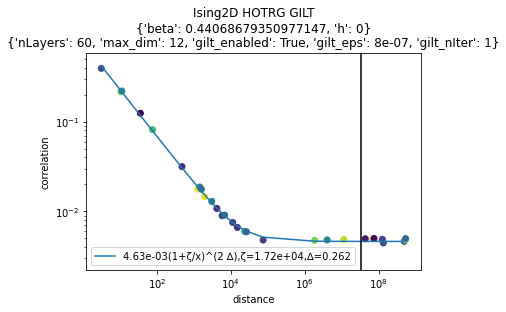

In [154]:
data['dist']=get_dist_torus_2D(data['x'].to_numpy(),data['y'].to_numpy(),lattice_size)


data['theta']=np.arctan2(data['x'],data['y'])


def ansatz1(x,A,zeta,delta): #high temperature
    return A*np.exp(-x/zeta)*x**(-2*delta)
ansatz1_eq='{0:.2e}e^(-x/ζ)/x^(2 Δ),ζ={1:.2e},Δ={2:.3f}'
ansatz1_p0=(1,100,0.1)

def ansatz3(x,A,zeta,delta,n): #low temperature
    return A*(1+(zeta/x)**n)**(2*delta/n)
ansatz3_eq='{0:.2e}(1+(ζ/x)^n)^(2 ∆/n),ζ={1:.2e},∆={2:.3f},n={3:.1f}'
ansatz3_p0=(1,100,0.1,2)

def ansatz4(x,A,zeta,delta):  #low temperature
    return A*(1+zeta/x)**(2*delta)
ansatz4_eq='{0:.2e}(1+ζ/x)^(2 ∆),ζ={1:.2e},∆={2:.3f}'
ansatz4_p0=(1,100,0.1)

def ansatz5(x,A,zeta,delta,m0):  #low temperature nikko
    return A*np.exp(-x/zeta)*x**(-2*delta)+m0**2
ansatz5_eq='{0:.2e}e^(-x/ζ)/x^(2 Δ)+m0^2,ζ={1:.2e},Δ={2:.3f},m0={3:.3f}'
ansatz5_p0=(1,1000,0.1,0.1)


    

def loglog(foo):
    @wraps(foo)
    def goo(logX,*p):
        return np.log(foo(np.exp(logX),*p))
    return goo



if data['correlation'].min()<1e-5:
    ansatz,ansatz_eq,ansatz_p0=ansatz1,ansatz1_eq,ansatz1_p0
    threshold=min(data[data['correlation']>1e-2]['dist'].max(),2**(options['nLayers']//2-5))
else:
    #ansatz,ansatz_eq,ansatz_p0=ansatz3,ansatz3_eq,ansatz3_p0
    ansatz,ansatz_eq,ansatz_p0=ansatz4,ansatz4_eq,ansatz4_p0
    #ansatz,ansatz_eq,ansatz_p0=ansatz5,ansatz5_eq,ansatz5_p0
    threshold=2**(options['nLayers']//2-5)

data1=data[(data['dist']<threshold)].sort_values('dist')

try:
    p,cov=curve_fit(loglog(ansatz),np.log(data1['dist']),np.log(data1['correlation']),p0=ansatz_p0,maxfev=10000)
except Exception as err:
    print(err)
    p,cov=None,None

data1=data.sort_values('dist')
plt.scatter(data1['dist'],np.abs(data1['correlation']),c=data1['theta'])
if p is not None:
    plt.plot(data1['dist'],ansatz(data1['dist'],*p),'-',label=ansatz_eq.format(*p))
    plt.legend()
plt.axvline(threshold,color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('distance')
plt.ylabel('correlation')
plt.ylim([max(1e-5,data['correlation'].min()*.5),data['correlation'].max()*1.5])
plt.title(f'{type(model).__name__} HOTRG GILT\n{params}\n{options}')
plt.show()

# diagonal TRG method

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

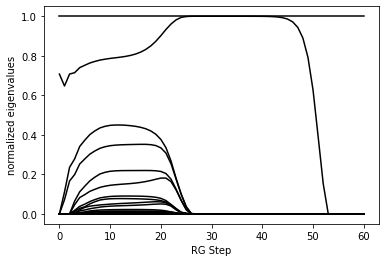

  0%|          | 0/61 [00:00<?, ?it/s]

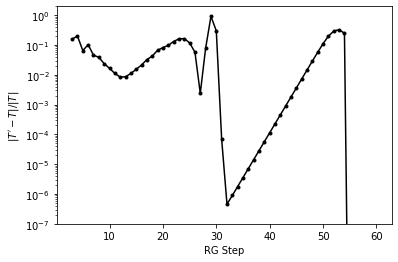

  0%|          | 0/61 [00:00<?, ?it/s]

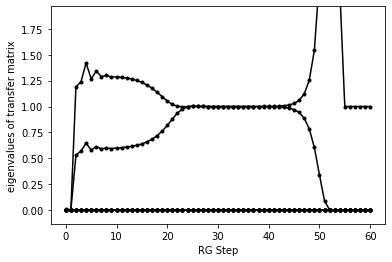

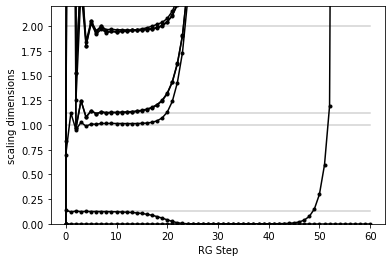

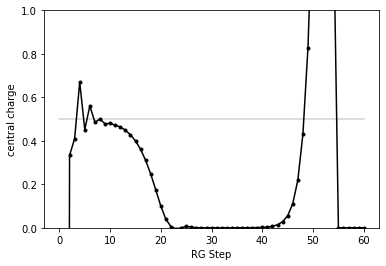

In [23]:
options={
    'nLayers':60,
    'max_dim':12,
    'gilt_enabled':True,
    'gilt_eps':8e-7,
    'gilt_nIter':1,
    'gilt_TRG_method':'A',
}
gilt_options=GILT_options(**{k[5:]:v for k,v in options.items() if k[:5]=='gilt_'})


#critical beta: 0.44068679350977147
params={'beta':.4409}
#params={'beta':0.44068679350977147}#critical
model=Ising2D(params)



Ts,logNorms=evolve_TRG_GILT_2D(model.get_T0(),
                               nLayers=options['nLayers'],max_dim=options['max_dim'],
                               options=gilt_options,
                               return_layers=True)
show_effective_rank(Ts)
show_diff(Ts)
curve=show_scaling_dimensions(Ts,loop_length=2,reference_scaling_dimensions=[0.125,1,1.125,2],reference_center_charge=.5)
# two_pass seems give higher cT: one_pass=.440606 two_pass=.440618 ref=.440686 max_dim=8
# not spliting insertion greatly changes cT: one_pass=.440298 two_pass=.440803 max_dim=8